# Mock QCNN Loss History

In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import Hybrid_nn
import torch
from torch import nn
import data
import pennylane as qml
import embedding

In [3]:
PATH_LH0 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Mock/Loss_not_trained.txt'
PATH_LH2 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Mock/Loss_Model2.txt'
PATH_LH3 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Mock/Loss_Model3.txt'

PATH_w0 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Mock/weights_not_trained.txt'
PATH_w2 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Mock/weights_Model2.txt'
PATH_w3 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Mock/weights_Model3.txt'

def data_read(PATH):
  textfile = open(PATH, 'r')
  data = np.array([])
  for line in textfile:
    a = np.array([float(v) for v in line.strip().split(" ")])
    data = np.append(data, a)
  return data

Loss_histories_not_trained = data_read(PATH_LH0).reshape(3,100)
Loss_histories_Model2 = data_read(PATH_LH2).reshape(3,100)
Loss_histories_Model3 = data_read(PATH_LH3).reshape(3,100)

weights_not_trained = data_read(PATH_w0).reshape(3,4)
weights_Model2 = data_read(PATH_w2).reshape(3,4)
weights_Model3 = data_read(PATH_w3).reshape(3,4)


Not_trained_mean, Not_trained_std = Loss_histories_not_trained.mean(axis=0), Loss_histories_not_trained.std(axis=0)
Model2_mean, Model2_std = Loss_histories_Model2.mean(axis=0), Loss_histories_Model2.std(axis=0)
Model3_mean, Model3_std = Loss_histories_Model3.mean(axis=0), Loss_histories_Model3.std(axis=0)

In [6]:
LB_before_traindata = 0.5 * (1 - 0.2734867334365845)
LB_Model2_traindata = 0.5 * (1 - 0.8831765055656433)
LB_Model3_traindata = 0.5 * (1 - 0.910000741481781)

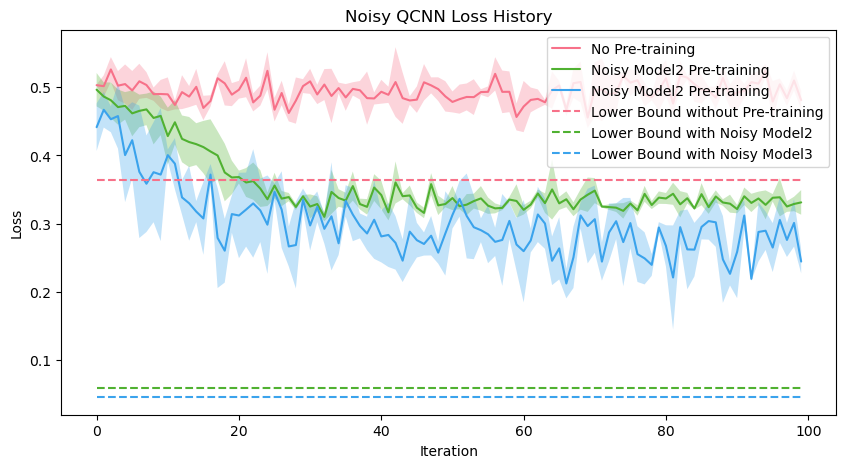

In [7]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):
    ax.plot(range(len(Not_trained_mean)), Not_trained_mean, label="No Pre-training", c=clrs[0])
    ax.fill_between(range(len(Not_trained_mean)), Not_trained_mean-Not_trained_std, Not_trained_mean+Not_trained_std, alpha=0.3,facecolor=clrs[0])
    
    ax.plot(range(len(Model2_mean)), Model2_mean, label="Noisy Model2 Pre-training", c=clrs[1])
    ax.fill_between(range(len(Model2_mean)), Model2_mean-Model2_std, Model2_mean+Model2_std, alpha=0.3,facecolor=clrs[1])

    ax.plot(range(len(Model3_mean)), Model3_mean, label="Noisy Model2 Pre-training", c=clrs[2])
    ax.fill_between(range(len(Model3_mean)), Model3_mean-Model3_std, Model3_mean+Model3_std, alpha=0.3,facecolor=clrs[2])


    ax.plot(range(100), np.ones(100) * LB_before_traindata, linestyle='dashed', linewidth=1.5, label="Lower Bound without Pre-training", c=clrs[0])
    ax.plot(range(100), np.ones(100) * LB_Model2_traindata, linestyle='dashed', linewidth=1.5, label="Lower Bound with Noisy Model2", c=clrs[1])
    ax.plot(range(100), np.ones(100) * LB_Model3_traindata, linestyle='dashed', linewidth=1.5, label="Lower Bound with Noisy Model3", c=clrs[2])


ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("Noisy QCNN Loss History")
ax.legend()

# Mock QCNN Accuracy

In [8]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import IBMQ
from qiskit.providers.fake_provider import FakeJakarta, FakeMontreal
from qiskit_aer.noise import NoiseModel


noisy = FakeJakarta()
noise_model = NoiseModel.from_backend(noisy)
coupling_map = noisy.configuration().coupling_map
basis_gates = noise_model.basis_gates

dev = qml.device(
    'qiskit.aer',
    wires=4,
    shots=1024,
    noise_model=noise_model,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

PATH_Model2 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Mock/Model2.pt'
PATH_Model3 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Mock/Model3.pt'

In [9]:
class x_transform2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
        
    def forward(self, x):
        x = self.linear_relu_stack2(x)
        return x.detach().numpy()


class x_transform3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        return x.detach().numpy()

model2 = x_transform2()
model3 = x_transform3()

In [10]:
def statepreparation(x, Trained):
    if Trained == False:
        embedding.Noisy_Four_QuantumEmbedding1(x)
    elif Trained == 'Model2':
        model2.load_state_dict(torch.load(PATH_Model2))
        x = model2(torch.tensor(x))
        embedding.Noisy_Four_QuantumEmbedding2(x)
    elif Trained == 'Model3':
        model3.load_state_dict(torch.load(PATH_Model3))
        x = model3(torch.tensor(x))
        embedding.Noisy_Four_QuantumEmbedding2(x[0])
    

@qml.qnode(dev)
def Noisy_QCNN_classifier(params, x, Trained):
    param1 = params[0:2]
    param2 = params[2:4]

    statepreparation(x, Trained)
    embedding.U_TTN(param1, wires=[0,1])
    embedding.U_TTN(param1, wires=[3,2])
    embedding.U_TTN(param2, wires=[1,2])
    return qml.expval(qml.PauliZ(2))

Model2

In [11]:

feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

/var/folders/ym/ry24dhs911s7zbqfbhs5ns2m0000gn/T/ipykernel_10570/461388107.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/torch/csrc/utils/tensor_new.cpp:233.)
  X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)


In [12]:
def accuracy_test(predictions, labels):
    acc = 0
    for l, p in zip(labels, predictions):
        if np.abs(l - p) < 1:
            acc = acc + 1
    return acc / len(labels)


accuracies_not_trained, accuracies_Model1, accuracies_Model2 = [], [], []

for i in range(3):
    prediction_not_trained = [Noisy_QCNN_classifier(weights_not_trained[i], x, Trained=False) for x in X_test]
    prediction_Model2 = [Noisy_QCNN_classifier(weights_Model2[i], x, Trained='Model2') for x in X_test]
    
    accuracy_not_trained = accuracy_test(prediction_not_trained, Y_test)
    accuracy_Model2 = accuracy_test(prediction_Model2, Y_test)

    accuracies_not_trained.append(accuracy_not_trained)
    accuracies_Model2.append(accuracy_Model2)

accuracies_not_trained, accuracies_Model2 = np.array(accuracies_not_trained), np.array(accuracies_Model2)

/Users/tak/miniforge3/envs/QC/lib/python3.10/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/var/folders/ym/ry24dhs911s7zbqfbhs5ns2m0000gn/T/ipykernel_10570/1434021917.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = model2(torch.tensor(x))


Model3

In [13]:
feature_reduction = False
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)

X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]


In [14]:
accuracies_Model3 = []

for i in range(3):
    prediction_Model3 = [Noisy_QCNN_classifier(weights_Model3[i], x, Trained='Model3') for x in X_test]
    accuracy_Model3 = accuracy_test(prediction_Model3, Y_test)
    accuracies_Model3.append(accuracy_Model3)

accuracies_Model3 = np.array(accuracies_Model3)

/var/folders/ym/ry24dhs911s7zbqfbhs5ns2m0000gn/T/ipykernel_10570/1434021917.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = model3(torch.tensor(x))


In [15]:

print("Noisy QCNN classification accuracies:\n")
print("-------------------------------------\n")
print(f" Accuracy without pre-training: {accuracies_not_trained.mean()} ± {accuracies_not_trained.std()}")
print(f" Accuracy after pre-training with Noisy_Model2: {accuracies_Model2.mean()} ± {accuracies_Model2.std()}")
print(f" Accuracy after pre-training with Noisy_Model3: {accuracies_Model3.mean()} ± {accuracies_Model3.std()}")

Noisy QCNN classification accuracies:

-------------------------------------

 Accuracy without pre-training: 0.5569739952718676 ± 0.016214116500692405
 Accuracy after pre-training with Noisy_Model2: 0.9804570527974783 ± 0.0012409783883391367
 Accuracy after pre-training with Noisy_Model3: 0.9725768321513003 ± 0.018057917210278936
